<a href="https://colab.research.google.com/github/ReginaTetslav/Funnel-1/blob/main/Funnel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# РАЗБИРАЕМСЯ КАК ПОСТРОИТЬ ВОРОНКУ САМОМУ, ИСПОЛЬЗУЯ СЫРЫЕ ДАННЫЕ.

**Исходные данные и задача:**
У нас есть [data_set](https://drive.google.com/file/d/1T8cbw_AOQTUSw9mqqFez41tbMSoAmAKA/view?usp=sharing) с сырыми данными о поведении пользователей за 5 месяцев.


*Ситуация:* Реселлер мотоциклов и комплектующих Harley Davidson ведет свой бизнес в трех городах в Москве, Санкт-Петербурге и Калининграде. Пользователи приходят, главным образом, из двух каналов - Facebook и ВКонтакте. Кроме того, есть данные о типе устройства, с которого пользователь зашел на сайт. Владелец бизнеса интересуется, как устроено поведение пользователя от его появления в магазине до обработки его заявки на обратную связь. Так как доход формируется преимущественно с продаж мотоциклов, то интересны в первую очередь они.

**Что делаем?** 


1.   При помощи [Google Colab](https://colab.research.google.com/) и [готового кода](https://drive.google.com/file/d/1dNpZxVkvwqN_eAue59PKFjNd-llu-moO/view) мы загружем и обрабатываем файл с сырыми данными - [data_set](https://drive.google.com/file/d/1T8cbw_AOQTUSw9mqqFez41tbMSoAmAKA/view). 



In [1]:
!pip3 install retentioneering

In [2]:
import pandas as pd
import io
import retentioneering
import numpy as np
import datetime
from copy import deepcopy
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

%matplotlib inline

2. Выделяем основные этапы взаимодействия пользователя с сайтом.

In [3]:
retentioneering.config.update({
    'event_col':'event',
    'event_time_col':'timestamp',
    'user_col': 'client_id'
})

Код построения и визуализации воронок взят из https://medium.com/multiplyai/user-conversion-funnel-9d957ce3e80c

In [4]:
def create_funnel_df(df, steps, from_date=None, to_date=None, step_interval=0, closed=True):
    """
    Function used to create a dataframe that can be passed to functions for generating funnel plots.
    """
    # filter df for only events in the steps list
    df = df[['client_id', 'mapped_event', 'timestamp']]
    df = df[df['mapped_event'].isin(steps)]

    values = []
    # for the rest steps, create a df and filter only for that step
    for i, step in enumerate(steps):
        if i == 0:
            dfs = {}

            dfs[step] = df[df['mapped_event'] == step] \
                .sort_values(['client_id', 'timestamp'], ascending=True) \
                .drop_duplicates(subset=['client_id', 'mapped_event'], keep='first')

            # filter df of 1st step according to dates
            if from_date:
                dfs[step] = dfs[step][(dfs[step]['timestamp'] >= from_date)]

            if to_date:
                dfs[step] = dfs[step][(dfs[step]['timestamp'] <= to_date)]

        else:
            dfs[step] = df[df['mapped_event'] == step]
            if not closed:
                dfs[step].drop_duplicates(subset=['client_id'], inplace=True)
            else:
                # outer join with previous step
                merged = pd.merge(dfs[steps[i - 1]], dfs[step], on='client_id', how='outer')

                # keep only rows for which the distinct_ids appear in the previous step
                valid_ids = dfs[steps[i - 1]]['client_id'].unique()
                merged = merged[merged['client_id'].isin(valid_ids)]

                # keep only events that happened after previous step and sort by time
                merged = merged[merged['timestamp_y'] >=
                                (merged['timestamp_x'] + pd.Timedelta(step_interval))].sort_values('timestamp_y', ascending=True)

                # take the minimum time of the valid ones for each user
                merged = merged.drop_duplicates(subset=['client_id', 'mapped_event_x', 'mapped_event_y'], keep='first')

                # keep only the necessary columns and rename them to match the original structure
                merged = merged[['client_id', 'mapped_event_y', 'timestamp_y']].rename({'mapped_event_y': 'mapped_event',
                                                                             'timestamp_y': 'timestamp'}, axis=1)

                # include the df in the df dictionary so that it can be joined to the next step's df
                dfs[step] = merged

        # append number of users to the "values" list
        values.append(len(dfs[step]))

    # create dataframe
    funnel_df = pd.DataFrame({'step': steps, 'val': values})
    # calculate percentage conversion for each step
    funnel_df['pct'] = (100 - 100 * abs(funnel_df['val'].pct_change()).fillna(0)).astype(int)
    # shift val by one to plot faded bars of previous step in background
    funnel_df['val-1'] = funnel_df['val'].shift(1)
    # calculate percentage conversion between each step and the first step in the funnel
    funnel_df['pct_from_first'] = (funnel_df['val'] / funnel_df['val'].loc[0] * 100).fillna(0).astype(int)

    return funnel_df


def group_funnel_dfs(events, steps, col, closed=True):
    """
    Function used to create a dict of funnel dataframes used to generate a stacked funnel plot.
    """
    dict_ = {}
    
    # get the distinct_ids for each property that we are grouping by
    ids = dict(events.groupby([col])['client_id'].apply(set))

    for entry in events[col].dropna().unique():
        ids_list = ids[entry]
        df = events[events['client_id'].isin(ids_list)].copy()
        if len(df[df['mapped_event'] == steps[0]]) > 0:
            dict_[entry] = create_funnel_df(df, steps, closed=closed)

    return dict_


def plot_stacked_funnel(events, steps, col=None, from_date=None, to_date=None, step_interval=0, closed=True):
    """
    Function used for producing a (stacked) funnel plot.
    """
    # create list to append each trace to
    # this will be passed to "go.Figure" at the end
    data = []

    # if col is provided, create a funnel_df for each entry in the "col"
    if col:
        # generate dict of funnel dataframes
        dict_ = group_funnel_dfs(events, steps, col, closed=closed)
        title = 'Funnel plot per {}'.format(col)
    else:
        funnel_df = create_funnel_df(events, steps, from_date=from_date, to_date=to_date, step_interval=step_interval, closed=closed)
        dict_ = {'Total': funnel_df}
        title = 'Funnel plot'

    for t in dict_.keys():
        trace = go.Funnel(
            name=t,
            y=dict_[t].step.values,
            x=dict_[t].val.values,
            textinfo="value+percent previous"
        )
        data.append(trace)

    layout = go.Layout(margin={"l": 180, "r": 0, "t": 30, "b": 0, "pad": 0},
                       funnelmode="stack",
                       showlegend=True,
                       hovermode='closest',
                       title='Funnel plot per {}'.format(col),
                       legend=dict(orientation="v",
                                   bgcolor='#E2E2E2',
                                   xanchor='left',
                                   font=dict(
                                       size=12)
                                   )
                       )

    return go.Figure(data, layout)

In [5]:
from google.colab import files
uploaded=files.upload()


Saving data_set.csv to data_set.csv


In [6]:
data = pd.read_csv(io.StringIO(uploaded['data_set.csv'].decode('utf-8')),sep=',')
#data = pd.read_csv('C:/Users/user/Desktop/SkillBox/data_set.csv')

data['timestamp'] = pd.to_datetime(data['timestamp'])
data = data.sort_values('timestamp')

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 69841 entries, 5364 to 229
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   channel    69841 non-null  object        
 1   client_id  69841 non-null  int64         
 2   event      69841 non-null  object        
 3   platform   69841 non-null  object        
 4   region     69841 non-null  object        
 5   timestamp  69841 non-null  datetime64[ns]
 6   user_type  69841 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(5)
memory usage: 4.3+ MB


Посмотрим на наши данные

In [8]:
data.head()

,channel,client_id,event,platform,region,timestamp,user_type
5364,fb,924523693,main,PC,spb,2019-11-02 17:16:00.881390,user__search
56879,vk,810735621,catalog/motobikes,android,moscow,2019-11-02 17:20:35.095998,user__search
21745,fb,168343349,catalog/motobikes,PC,moscow,2019-11-02 17:26:42.287648,user__search
21746,fb,168343349,"catalog/motobikes/Road Glide Limited 114, Harl...",PC,moscow,2019-11-02 17:26:42.414465,user__search
21747,fb,168343349,request_call,PC,moscow,2019-11-02 17:27:32.440646,user__search


Степ матрица показывает для каждого шага распределение по событиям произошедшим на этом шаге

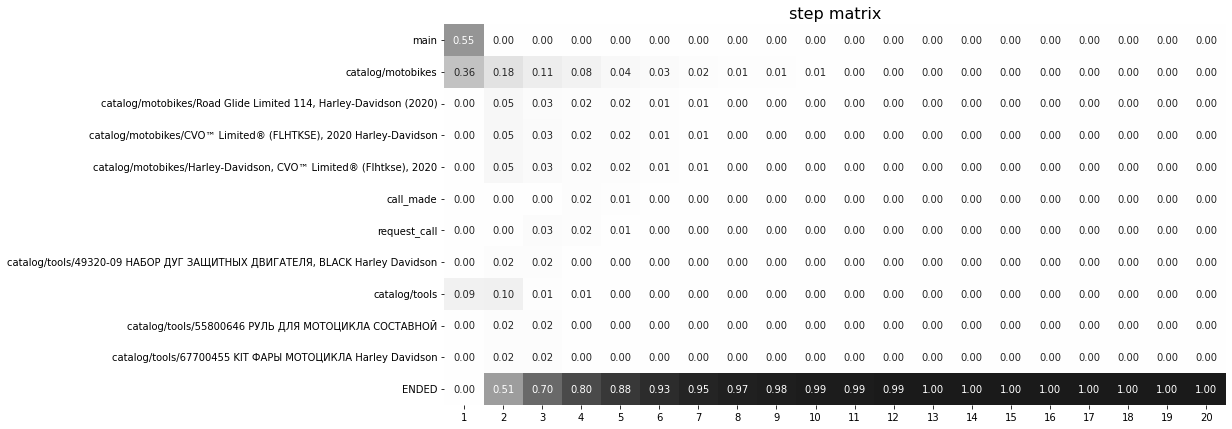

In [9]:
desc_table = data.rete.step_matrix(max_steps=20)

In [10]:
data['event'].value_counts()

catalog/motobikes                                                             26228
main                                                                          16515
catalog/tools                                                                  6296
catalog/motobikes/CVO™ Limited® (FLHTKSE), 2020 Harley-Davidson                4665
catalog/motobikes/Harley-Davidson, CVO™ Limited® (Flhtkse), 2020               4585
catalog/motobikes/Road Glide Limited 114, Harley-Davidson (2020)               4582
request_call                                                                   1922
call_made                                                                      1448
catalog/tools/49320-09 НАБОР ДУГ ЗАЩИТНЫХ ДВИГАТЕЛЯ, BLACK Harley Davidson     1217
catalog/tools/55800646 РУЛЬ ДЛЯ МОТОЦИКЛА СОСТАВНОЙ                            1215
catalog/tools/67700455 KIT ФАРЫ МОТОЦИКЛА Harley Davidson                      1168
Name: event, dtype: int64

Будем анализировать не все события, а только наиболее значимые

In [11]:
def map_event(event):
    if event in ('request_call'):
        return event
    elif event in ('main'):
        return 'main'
    elif event in ('catalog/motobikes'):
      return 'catalog_motobikes'
    elif event in ('catalog/motobikes/CVO™ Limited® (FLHTKSE), 2020 Harley-Davidson',
                   'catalog/motobikes/Harley-Davidson, CVO™ Limited® (Flhtkse), 2020',
                   'catalog/motobikes/Road Glide Limited 114, Harley-Davidson (2020)'):
      return 'catalog_motobikes_page'
    else:
        return None

In [12]:
data['mapped_event'] = list(map(map_event, data['event']))

In [13]:
data.dropna(subset=['mapped_event'], inplace=True)

Это список выделенных событий, какие то из сырых событий мы склеили в одно, какие то выбросили

In [14]:
stages = ['main',
          'catalog_motobikes',
          'catalog_motobikes_page',
          'request_call']

3. Чтобы провести анализ конверсии в определенные события и ответить на вопрос: 'Каково поведение в магазине покупателей мотоциклов', используем воронку.
Строим открытые и закрытые воронки. И анализируем воронки в разрезе трех параметров: Город. Рекламный канал, с которого пришел пользователь. Тип устройства пользователя.
Смотрим есть ли проблемы с конверсией пользователей из разных сегментов. На каких этапах и с чем это может быть связано. 

#### 1) Закрытая воронка по типу Географии - Москва, Санкт-Петербург, Калининград.

Показывает для каждого этапа, сколько пользователей до него дошли, пройдя все предыдущие: абсолютное значение пользователей и конверсию из предыдущего этапа.

In [15]:
plot_stacked_funnel(data, stages, col='region')

Воронка показывает похожее поведение пользователей разных городов. Цифры конверсии по этапам продвижения по сайту схожи. Московский трафик самый большой, так как изначально является самым большим потребительским рынком страны. 

#### 2) Открытая воронка по типу География

Отличие от закрытой воронки - пользователь будет учтен на очередном этапе, независимо от прохождения им предыдущих. Из за этого количество пользователей не обязано убывать по мере прохождения воронки

In [16]:
plot_stacked_funnel(data, stages, col='region', closed=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Открытую воронку по городам можно охарактеризовать, как похожую на закрытую - показатели конверсии городов схожи по активности пользователей. По открытой воронке мы видим, что основной поток пользователей сначала приводится в Каталог.

### 1) Закрытая воронка по типу Канала трафика.

In [17]:
plot_stacked_funnel(data, stages, col='channel')

Все показатели по каналу из FB значительно выше, чем показатели по трафику из VK, а именно все цифры по конверсиям на всех ступенях воронки. И охват самого трафика из FB изначально.
То есть канал FB для продвижения магазина мотоциклов является более эффективным и основным, чем VK. VK - является дополнительным источником трафика. Мы должны проанализировать целесообразность затрат на канал VK.


### 2) Открытая воронка по типу Канала трафика.

In [18]:
plot_stacked_funnel(data, stages, col='channel', closed=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Открытая воронка показывает, что основной поток трафика из рекламной кампании приходит сразу в каталог магазина.
Активнее на рекламу откликаются пользователи FB. Количественно по заказу обратного звонка цифры Facebook выше, несмотря на то, конверсия последней ступени в Событие немного ниже, чем у пользователей VK. 
В целом FB - наиболее эффективный инструмент для магазина. 

### 1) Закрытая воронка по типу устройста пользователя.

In [19]:
plot_stacked_funnel(data, stages, col='platform')

Самое большое количество приходов с устройств Android, на порядок меньше и почти в равном количестве заходят на сайт пользователи IOS и PC. Самое большое количество заказов обратного звонка с PC - 364, гораздо меньше с Android - 119 и самое малое количество заказанных звонков с IOS -  100. Наиболее эффективными выглядят показатели конверсии в обратный звонок пользователей PC.

### 2) Открытая воронка по типу устройства пользователя. 

In [20]:
plot_stacked_funnel(data, stages, col='platform', closed=False)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



По открытой воронке мы видим более результативные показатели по конверсии, чем мы видели в закрытой воронке. Очевидно, что пользователи приходят сразу в каталоговые страницы. И самая высокая конверсия 25% в заказанный звонок от посетителей с PC. И только 6% c IOS и 5% c Android. Возможно в данном случае следует посмотреть, что мешает пользователям, которые пришли со смартфонов конвертироваться также успешно, как с PC на последней ступени к заказу обратного звонка, возможно пользователям смартфонов удобнее сразу совершать звонок, чем его заказывать. 
Показатели открытой воронки совем не совпадают с результатами закрытой воронки. И путь по открытой воронке выглядит наиболее эффективным по конечному событию "Заказ обратного звонка". В абсолютных цифрах показатель заказа обратного звонка по открытой воронке составляет  - 1922, в то время как показатель заказа обратного звонка по закрытой воронке составил - 583. 